<a href="https://colab.research.google.com/github/PLEX-GR00T/Data_Mining/blob/main/Part_TFv2.0_TensorRT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1 : Download the Data and Load the model

In [1]:
!nvidia-smi

Sun May 22 02:37:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install tflite_model_maker
##installing model maker

  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.0.2
    Uninstalling tensorboard-2.0.2:
      Successfully uninstalled tensorboard-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.0.0 requires tensorboard<2.1.0,>=2.0.0, but you have tensorboard 2.8.0 which is incompatible.


## install TensorFlow-GPU 2.0

We have to do this for this assignment becase TFv2.8 is not showing TensorRT installation in the Google Colab by default, but they claim they do, and if so i was not able to do that.


In [3]:
!pip install pillow matplotlib
!pip install tensorflow-gpu==2.0.0

  Using cached tensorboard-2.0.2-py3-none-any.whl (3.8 MB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.0.2 which is incompatible.


In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

In [5]:
print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.0.0
Hub version:  0.12.0
Eager mode:  True
GPU is available


In [6]:
import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

In [7]:
import tensorflow as tf
print("Tensorflow version: ", tf.version.VERSION)

Tensorflow version:  2.0.0


# Load Data

In [8]:
!pip install kaggle

In [9]:
! mkdir /content/drive/MyDrive/kaggle

mkdir: cannot create directory ‘/content/drive/MyDrive/kaggle’: File exists


In [10]:
!ls /content/drive/MyDrive/kaggle

kaggle.json


In [11]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"

In [12]:
%cd /content/drive/MyDrive/kaggle

/content/drive/MyDrive/kaggle


## Load the data

In [13]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

gtsrb-german-traffic-sign.zip: Skipping, found more recently modified local copy (use --force to force download)


In [14]:
%ls

kaggle.json


In [15]:
!kaggle config view #View current config values

Configuration values from /content/drive/MyDrive/kaggle
- username: gr00t16
- path: /content
- proxy: None
- competition: None


In [16]:
!kaggle config set -n path -v /content

- path is now set to: /content


In [17]:
#changing the working directory
%cd /content/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
!pwd
!ls

/content/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
/content/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
gtsrb-german-traffic-sign.zip				   test
meta							   Test
Meta							   Test.csv
Meta.csv						   train
my_model						   Train
my_model.h5						   Train.csv
nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb  training_1


In [18]:
!unzip -qq gtsrb-german-traffic-sign.zip

replace Meta.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [19]:
os.chdir('/content/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign')
!ls 

gtsrb-german-traffic-sign.zip				   test
meta							   Test
Meta							   Test.csv
Meta.csv						   train
my_model						   Train
my_model.h5						   Train.csv
nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb  training_1


In [20]:
train_df = pd.read_csv('Train.csv')
# display a sneak peek of the data
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [21]:
print(f'Number of classes: {train_df.ClassId.unique().shape[0]}')

Number of classes: 43


In [22]:
labels = ['20 km/h', '30 km/h', '50 km/h', '60 km/h', '70 km/h', '80 km/h', '80 km/h end', '100 km/h', '120 km/h', 'No overtaking',
               'No overtaking for trucks', 'Crossroad with secondary way', 'Main road', 'Give way', 'Stop', 'Road up', 'Road up for truck', 'No entry',
               'Other dangerous', 'Turn left', 'Turn right', 'Winding road', 'Hollow road', 'Slippery road', 'Narrowing road', 'Roadwork', 'Traffic light',
               'Pedestrian', 'Children', 'Bike', 'Snow', 'Deer', 'End of the limits', 'Only right', 'Only left', 'Only straight', 'Only straight and right', 
               'Only straight and left', 'Take right', 'Take left', 'Circle crossroad', 'End of overtaking limit', 'End of overtaking limit for truck']

In [23]:
# add column with readable labels
train_df['Label'] = train_df['ClassId'].replace(sorted(train_df['ClassId'].unique()), labels)
# print updated df
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,Label
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,Turn right
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,Turn right
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,Turn right
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,Turn right
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,Turn right


In [24]:
train_df.shape

(39209, 9)

In [25]:
base_dir = '/content/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/Train'
print(base_dir)

/content/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/Train


In [26]:
IMAGE_SIZE = 160
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2) #Normalizing

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')#dividing image_size, batch_size

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [27]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape #each image is 224x224x4

((64, 160, 160, 3), (64, 43))

In [28]:
from time import time
#performing same process on the dataset
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/feature_vector/5",
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(43, activation='softmax')
])
model.build([None, 160, 160, 3]) 

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  829536    
_________________________________________________________________
dense (Dense)                multiple                  22059     
Total params: 851,595
Trainable params: 22,059
Non-trainable params: 829,536
_________________________________________________________________


In [29]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [30]:
!pip install pyyaml h5py 

In [31]:
# Run model training
from time import time
#performing same process on the dataset
start_opt = time()
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(val_generator.samples/val_generator.batch_size)

checkpoint_path = "training_1/cp.ckpt" ##training saves weights that are done during training
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
hist = model.fit(
    train_generator, 
    epochs=10,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    callbacks=[cp_callback]).history
finish_opt = time()
f"Execution time with TensorFlow to train: {(finish_opt - start_opt):.2f} s"

Train for 491.0 steps, validate for 123.0 steps
Epoch 1/10
490/491 [============================>.] - ETA: 0s - loss: 1.5563 - acc: 0.5699
Epoch 00001: saving model to training_1/cp.ckpt
491/491 [==============================] - 46s 93ms/step - loss: 1.5550 - acc: 0.5701 - val_loss: 1.4997 - val_acc: 0.5557
Epoch 2/10
488/491 [============================>.] - ETA: 0s - loss: 0.7521 - acc: 0.8002
Epoch 00002: saving model to training_1/cp.ckpt
491/491 [==============================] - 41s 84ms/step - loss: 0.7518 - acc: 0.8002 - val_loss: 1.3443 - val_acc: 0.6044
Epoch 3/10
488/491 [============================>.] - ETA: 0s - loss: 0.5567 - acc: 0.8534
Epoch 00003: saving model to training_1/cp.ckpt
491/491 [==============================] - 31s 62ms/step - loss: 0.5564 - acc: 0.8534 - val_loss: 1.2938 - val_acc: 0.6290
Epoch 4/10
489/491 [============================>.] - ETA: 0s - loss: 0.4532 - acc: 0.8825
Epoch 00004: saving model to training_1/cp.ckpt
491/491 [==================

'Execution time with TensorFlow to train: 359.58 s'

In [32]:
os.listdir(checkpoint_dir)

['checkpoint',
 'cp.ckpt.index',
 'cp.ckpt.data-00000-of-00002',
 'cp.ckpt.data-00001-of-00002']

In [33]:
prediction = time()
final_loss, final_accuracy = model.evaluate(val_generator, steps = val_steps_per_epoch)
predictend = time() - prediction
f"Inference time with TensorFlow : {(predictend):.2f} s"

123/123 [==============================] - 9s 74ms/step - loss: 1.3297 - acc: 0.6471


'Inference time with TensorFlow : 9.28 s'

In [34]:
x =model.predict(val_generator)

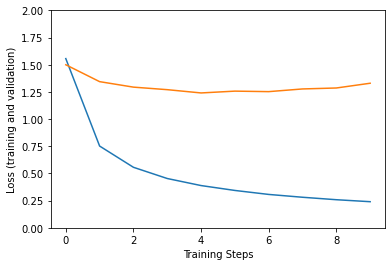

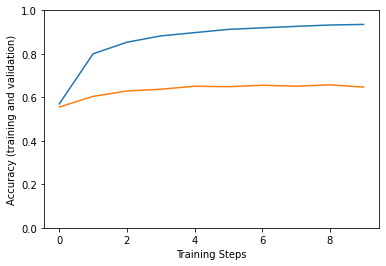

In [35]:
# Visualize training process

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

In [36]:
model.save('my_model.h5')

In [37]:
from tensorflow.keras.models import load_model

# Load HDF5 file using path

# save as Tesorflow SavedModel
model.save("my_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


In [38]:
!pip install pillow matplotlib
!pip install tensorflow-gpu==2.0.0

In [39]:
%%bash
wget https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb

dpkg -i nvidia-machine-learning-repo-*.deb
apt-get update

sudo apt-get install libnvinfer5

(Reading database ... 155650 files and directories currently installed.)
Preparing to unpack nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb ...
Unpacking nvidia-machine-learning-repo-ubuntu1804 (1.0.0-1) over (1.0.0-1) ...
Setting up nvidia-machine-learning-repo-ubuntu1804 (1.0.0-1) ...
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
H

--2022-05-22 02:45:05--  https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.195.19.142
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2926 (2.9K) [application/x-deb]
Saving to: ‘nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb.1’

     0K ..                                                    100%  143M=0s

2022-05-22 02:45:05 (143 MB/s) - ‘nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb.1’ saved [2926/2926]

W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list.d/nvidia-machine-learning.list:1 and /etc/apt/sources.list.d/nvidia-ml.list:1
W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list.d/nvidia-machine-learning.list:1

In [40]:
from tensorflow.python.client import device_lib

def check_tensor_core_gpu_present():
    local_device_protos = device_lib.list_local_devices()
    for line in local_device_protos:
        if "compute capability" in str(line):
            compute_capability = float(line.physical_device_desc.split("compute capability: ")[-1])
            if compute_capability>=7.0:
                return True
    
print("Tensor Core GPU Present:", check_tensor_core_gpu_present())
tensor_core_gpu = check_tensor_core_gpu_present() ###check GPU

Tensor Core GPU Present: None


In [41]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [42]:
img_path = '/content/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign'
model_path = '/content/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/my_model'

/content/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/Test
./00000.png
./00001.png
./00002.png
./00003.png


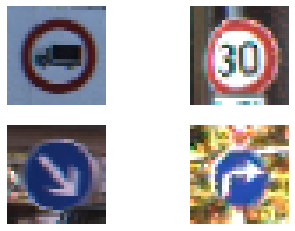

In [43]:
%cd /content/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/Test
from tensorflow.keras.preprocessing import image

fig, axes = plt.subplots(nrows=2, ncols=2)

for i in range(4):
  img_path = './0000%d.png' % (i % 4)
  print(img_path)
  img = image.load_img(img_path, target_size=(28, 28))
  plt.subplot(2,2,i+1)
  plt.imshow(img);
  plt.axis('off');

In [44]:
%cd /content
model = tf.keras.models.load_model(model_path)

/content


/content/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/Test
prediction shape: (1, 43)
Predicted Image class: End of the limits
prediction shape: (1, 43)
Predicted Image class: 70 km/h
prediction shape: (1, 43)
Predicted Image class: 70 km/h
prediction shape: (1, 43)
Predicted Image class: 70 km/h


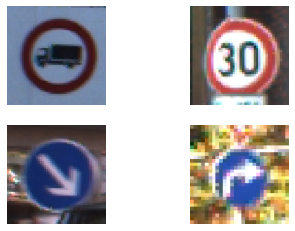

In [45]:
%cd /content/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/Test
for i in range(4):
  img_path = './0000%d.png'%i
  img = image.load_img(img_path, target_size=(160, 160))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  preds = model.predict(x)
  print("prediction shape:", preds.shape)
  classes = np.argmax(preds, axis = 1)
  print('Predicted Image class:', labels[int(classes)])
  plt.subplot(2,2,i+1)
  plt.imshow(img);
  plt.axis('off');

In [78]:
%cd /content/
model.save('saved_model') 

/content
INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


In [79]:
!saved_model_cli show --all --dir saved_model


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 160, 160, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['output_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 43)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict


# TF2.0 INFERENCE

In [80]:
model = tf.keras.models.load_model('saved_model')

/content/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/Test
prediction shape: (1, 43)
Predicted Image class: End of the limits
prediction shape: (1, 43)
Predicted Image class: 70 km/h
prediction shape: (1, 43)
Predicted Image class: 70 km/h
prediction shape: (1, 43)
Predicted Image class: 70 km/h


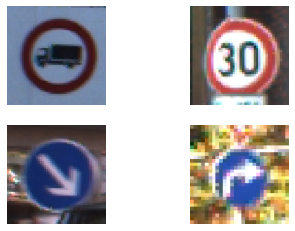

In [83]:
%cd /content/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/Test
for i in range(4):
  img_path = './0000%d.png'%i
  img = image.load_img(img_path, target_size=(160, 160))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  preds = model.predict(x)
  print("prediction shape:", preds.shape)
  classes = np.argmax(preds, axis = 1)
  print('Predicted Image class:', labels[int(classes)])
  plt.subplot(2,2,i+1)
  plt.imshow(img);
  plt.axis('off');

In [50]:
batch_size = 8
batched_input = np.zeros((batch_size, 160, 160, 3), dtype=np.float32)

for i in range(batch_size):
  img_path = './0000%d.png' % (i % 4)
  img = image.load_img(img_path, target_size=(160, 160))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  batched_input[i, :] = x
batched_input = tf.constant(batched_input)
print('batched_input shape: ', batched_input.shape)

batched_input shape:  (8, 160, 160, 3)


In [51]:
# Benchmarking throughput
import time
N_warmup_run = 50
N_run = 1000
elapsed_time = []

for i in range(N_warmup_run):
  preds = model.predict(batched_input)

for i in range(N_run):
  start_time = time.time()
  preds = model.predict(batched_input)
  end_time = time.time()
  elapsed_time = np.append(elapsed_time, end_time - start_time)
  if i % 50 == 0:
    print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

Step 0: 29.8ms
Step 50: 39.2ms
Step 100: 30.4ms
Step 150: 30.6ms
Step 200: 29.8ms
Step 250: 30.6ms
Step 300: 41.5ms
Step 350: 30.5ms
Step 400: 31.2ms
Step 450: 30.7ms
Step 500: 31.3ms
Step 550: 43.6ms
Step 600: 30.9ms
Step 650: 31.7ms
Step 700: 31.1ms
Step 750: 31.0ms
Step 800: 30.9ms
Step 850: 47.3ms
Step 900: 31.6ms
Step 950: 31.1ms
Throughput: 240 images/s


#HIS

In [70]:
img_path = '/content/drive/MyDrive/255_Final_Project/000.png' # Siberian_husky
img = image.load_img(img_path, target_size=(160, 160))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x = tf.constant(x)

In [53]:
model = tf.keras.models.load_model('/content/TF-TRT_saved_model')

In [67]:
t = time()
x = model.predict(val_generator)
print(np.argmax(x[0]))
print(np.argmax(val_generator[0][1]))
pr = time() - t
print("time taken:", pr)

4
4
time taken: 6.1210572719573975


In [71]:
t = time()
model = tf.keras.models.load_model('/content/TF-TRT_saved_model')
model.predict(x)
pr = time() - t
f"Inference time with TensorFlow : {(pr):.2f} s"

'Inference time with TensorFlow : 2.07 s'

In [73]:
from time import time
from tensorflow.python.saved_model import tag_constants

def benchmark_tftrt(saved_model_dir):
    saved_model_loaded = tf.saved_model.load(saved_model_dir, tags=[tag_constants.SERVING])
    infer = saved_model_loaded.signatures['serving_default']
    # convert to float32 and as tf constant
    batched_input = tf.constant(batched_input.astype("float32"))
    n_warmup_runs = 50
    n_runs = 1000

    # TensorRT requires a little steps to warmup for processing
    for i in range(n_warmup_runs):
      labeling = infer(batched_input)

    start_time = time.time()
    # run for 1000 steps with 8 batch size
    for i in range(n_runs):
      labeling = infer(batched_input)

    end_time = time.time()
    print('Throughput: {:.0f} images/s'.format(n_runs * batch_size / (end_time-start_time)))

In [74]:
print('Converting to TF-TRT FP32...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(precision_mode=trt.TrtPrecisionMode.FP32,
                                                               max_workspace_size_bytes=8000000000)

converter = trt.TrtGraphConverterV2(input_saved_model_dir='/content/TF-TRT_saved_model',
                                    conversion_params=conversion_params)
converter.convert()
converter.save(output_saved_model_dir='saved_model_TFTRT_FP32')
print('Done Converting to TF-TRT FP32')

Converting to TF-TRT FP32...
INFO:tensorflow:Linked TensorRT version: (5, 1, 5)


INFO:tensorflow:Linked TensorRT version: (5, 1, 5)


INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)


INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)


INFO:tensorflow:Running against TensorRT version 5.1.5


INFO:tensorflow:Running against TensorRT version 5.1.5


INFO:tensorflow:Assets written to: saved_model_TFTRT_FP32/assets


INFO:tensorflow:Assets written to: saved_model_TFTRT_FP32/assets


Done Converting to TF-TRT FP32


In [75]:
def predict_tftrt(input_saved_model,path):
    """Runs prediction on a single image and shows the result.
    input_saved_model (string): Name of the input model stored in the current dir
    """
    img_path = path # Siberian_husky
    img = image.load_img(img_path, target_size=(160, 160))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = tf.constant(x)
    
    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    signature_keys = list(saved_model_loaded.signatures.keys())
    print(signature_keys)

    infer = saved_model_loaded.signatures['serving_default']
    print(infer.structured_outputs)

    labeling = infer(x)
    print(labeling)

In [76]:
from time import time
st = time()
predict_tftrt('saved_model_TFTRT_FP32', '/content/drive/MyDrive/255_Final_Project/000.png')
en = time() - st

['serving_default']
{'output_1': TensorSpec(shape=<unknown>, dtype=tf.float32, name='output_1')}
{'output_1': <tf.Tensor: id=202526, shape=(1, 43), dtype=float32, numpy=
array([[2.2493237e-05, 9.2245057e-02, 3.1564231e-09, 4.6620946e-02,
        7.8668753e-03, 2.8967607e-04, 3.6120445e-02, 2.4015665e-07,
        1.0116485e-05, 2.5775752e-04, 6.1028261e-02, 1.1605173e-08,
        4.2698774e-04, 2.9129835e-06, 4.9068728e-07, 3.3805454e-01,
        1.0459706e-09, 9.5682251e-10, 2.5258478e-06, 2.9157572e-06,
        1.6423613e-04, 3.3544738e-06, 2.4395083e-13, 2.6444670e-06,
        9.6377995e-08, 8.7735128e-07, 7.4767350e-08, 1.5458709e-09,
        8.8168588e-04, 7.5297180e-07, 2.2191389e-10, 2.6448743e-07,
        6.9857349e-05, 2.5501838e-09, 3.9494038e-01, 3.0257524e-08,
        5.1095551e-08, 3.3653373e-13, 4.4758363e-07, 1.1896077e-11,
        6.7806747e-03, 1.0228130e-02, 3.9741360e-03]], dtype=float32)>}


In [77]:
f"Inference time with TensorRT : {(en):.2f} s"

'Inference time with TensorRT : 3.16 s'